<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Dense_network_v2_68*80nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/3/13 尝试了Dense autoencoder之后，效果一般，勉强能出数字1和9.因此决定尝试convolutional autoencoer

2020/3/14 成功将ssim作为loss function.

2020/3/14 利用新的ssim指标来尝试改变autoencoder结构,看看当结构趋向于CNN会有什么变化。

2020/3/16 修改autoencoder结构，验证这种结构的作用。

2020/3/23 Dense 效果这么好，我也来测试一下。

引入24小时数据，测试网络结构的transfer learning性能。

加入20epoch以上不再训练，并选取最优结果功能。

2020/3/25 尝试更大size的图像。
    


In [1]:
%tensorflow_version 1.x
from keras.layers import Input, Dense , Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import pickle
import numpy as np 

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/


/content/drive/My Drive/Colab Notebooks/MMF data


In [3]:
cd 24hours_Mix_datasets/24hours_img/

/content/drive/My Drive/Colab Notebooks/MMF data/24hours_Mix_datasets/24hours_img


In [0]:
with open('main_24hours_v2_80000_run2_big.dat','rb') as f:
  imgs_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_SLM.dat','rb') as f:
  origins_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_Records.dat','rb') as f:
  records = pickle.load(f)

In [5]:
np.shape(imgs_all)

(80000, 64, 80)

In [0]:
#convert records file into a array
N = [0]
for i in records:
  if i == 'Start point' or i == 'end point':
    pass
  else:
    N.append(records[i])

In [0]:
mnist_imgs = []
mnist_origins = []

#选取其中的mnist图片，如果要选择fashion_mnist，那么改为 i%2 == 0即可。
#N_12, N_15代表选取的是12 - 15 hours的图片。
for i in range(N[0], N[3]):
  if i % 2 == 1:
    mnist_imgs.append(imgs_all[i])
    mnist_origins.append(origins_all[i])


In [0]:
# for i in range(10000):
#   imgs[i] = imgs[i].flatten()
#   origins[i] = origins[i].flatten()

In [34]:
N_input = len(mnist_imgs)
N_train = int(0.8* N_input)
N_test = N_input - N_train
print('共有{}张图片，其中{}张为训练图片，{}张为测试图片'.format(N_input, N_train, N_test))

共有4808张图片，其中3846张为训练图片，962张为测试图片


In [0]:
imgs = np.array(mnist_imgs).astype(float)   
origins = np.array(mnist_origins).astype(float)

In [0]:
def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[ i] for i in idx]
    data_shuffle_output = [data_output[ i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)


In [0]:
# shuffle input datasets
imgs, origins = next_batch(N_input,imgs, origins)

train_imgs = imgs[0:N_train].reshape(-1,64,80,1)
train_origins = origins[0:N_train].reshape(-1,28,28,1)
test_imgs = imgs[N_train:N_input].reshape(-1,64,80,1)
test_origins = origins[N_train:N_input].reshape(-1,28,28,1)

for i in range(N_train):
  train_imgs[i] = train_imgs[i]/256.0
  train_origins[i] = train_origins[i]/256.0

for i in range(N_test):
  test_imgs[i] = test_imgs[i]/256.0
  test_origins[i] = test_origins[i]/256.0


Set up neural network

In [0]:
from keras.layers import Input,  Conv2D, MaxPooling2D, UpSampling2D , Flatten , Reshape , Dense ,Dropout
from keras.models import Model
from keras import backend as K
from keras.activations import sigmoid

我把原来的autoencoder结构用keras来重写了一次，基本结构是一样的。

In [0]:
input_img = Input(shape=(64, 80, 1))  # adapt this if using `channels_first` image data format

x = Flatten()(input_img)
x = Dense(64*80, activation = 'sigmoid')(x)
x = Dropout(0.2)(x)
x = Dense(784, activation='sigmoid')(x)
output = Reshape((28,28,1))(x)

autoencoder = Model(input_img, output)

In [198]:
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 80, 1)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 5120)              26219520  
_________________________________________________________________
dropout_23 (Dropout)         (None, 5120)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 784)               4014864   
_________________________________________________________________
reshape_11 (Reshape)         (None, 28, 28, 1)         0         
Total params: 30,234,384
Trainable params: 30,234,384
Non-trainable params: 0
______________________________________________

In [0]:
#  Back up for the network
# input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

# x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# latent_space = Flatten()(encoded)
# latent_space = Dense(10)(latent_space)
# latent_space = Dense(4*4*32)(latent_space)
# latent_space = Reshape((4,4,32))(latent_space)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_space)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# autoencoder = Model(input_img, decoded)

**This is the part for SSIM loss function**

In [0]:
import tensorflow as tf
import keras

def ssim_loss(y_true, y_pred):
  return 1.0-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


In [0]:
autoencoder.compile(optimizer = 'adam', loss = ssim_loss , metrics = [ssim_loss, 'accuracy'])
#autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = [ssim_loss, 'accuracy'])
#autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error' , metrics = [ssim_loss, 'accuracy'])

In [202]:
print (train_imgs.shape)
print (test_imgs.shape)

(3846, 64, 80, 1)
(962, 64, 80, 1)


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=20),     #patience represented epochs waited.
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [204]:
history = autoencoder.fit(train_imgs, train_origins,
                epochs=500,
                batch_size=32,
                callbacks=callbacks, # Early stopping
                shuffle=True,
                validation_data=(test_imgs, test_origins))

Train on 3846 samples, validate on 962 samples
Epoch 1/500
3846/3846 [==============================] - 6s 2ms/step - loss: 0.8219 - ssim_loss: 0.8219 - acc: 0.7265 - val_loss: 0.8132 - val_ssim_loss: 0.8132 - val_acc: 0.7385
Epoch 2/500
3846/3846 [==============================] - 3s 872us/step - loss: 0.8147 - ssim_loss: 0.8147 - acc: 0.7379 - val_loss: 0.8075 - val_ssim_loss: 0.8075 - val_acc: 0.7359
Epoch 3/500
3846/3846 [==============================] - 3s 882us/step - loss: 0.8032 - ssim_loss: 0.8032 - acc: 0.7430 - val_loss: 0.7905 - val_ssim_loss: 0.7905 - val_acc: 0.7455
Epoch 4/500
3846/3846 [==============================] - 3s 880us/step - loss: 0.7770 - ssim_loss: 0.7770 - acc: 0.7515 - val_loss: 0.7395 - val_ssim_loss: 0.7395 - val_acc: 0.7568
Epoch 5/500
3846/3846 [==============================] - 3s 893us/step - loss: 0.6564 - ssim_loss: 0.6564 - acc: 0.7733 - val_loss: 0.5922 - val_ssim_loss: 0.5922 - val_acc: 0.7787
Epoch 6/500
3846/3846 [===========================

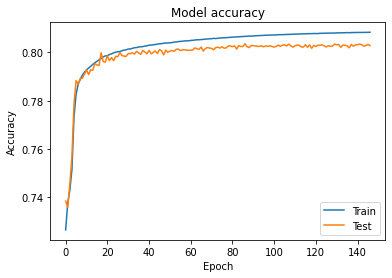

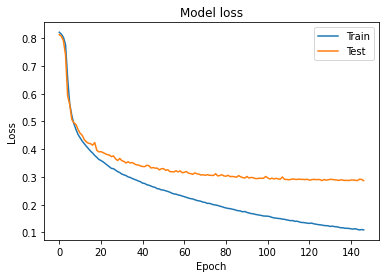

In [205]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc= 'lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Test average SSIM

**Import the pre-trained Mnist classification network: Detective**

In [0]:
from tensorflow.keras.models import load_model

Detective = load_model('/content/drive/My Drive/Colab Notebooks/MMF data/Mnist image data/my_model.h5')

In [0]:
autoencoder.load_weights('best_model.h5')


In [0]:
decoded_imgs = autoencoder.predict(test_imgs)

**Average SSIM test**


In [217]:
import time
from skimage.metrics import structural_similarity as ssim


Number = 500

#x_test_noisy , imgs_test = next_batch (Number , train_imgs, train_origins)
x_test_noisy , imgs_test = next_batch (Number , test_imgs, test_origins)

x_test_noisy = x_test_noisy.reshape((-1,64,80,1))
imgs_test = imgs_test.reshape((-1,28,28,1))

c_1 = time.time()
recon_img = autoencoder.predict(x_test_noisy)
c_2 = time.time()

SSIM_test = []

for i in range(Number):
  s =ssim(recon_img[i],imgs_test[i], multichannel = True)
  SSIM_test.append(s)

print('reconstruction time = {:.4f}s'.format(c_2-c_1))
print('average SSIM = {:.2f}'.format(sum(SSIM_test)/Number))
print('SSIM variance = {:.4f}'.format(np.var(SSIM_test)))

answer1 = Detective.predict(recon_img.reshape(-1,28,28))
answer2 = Detective.predict(imgs_test.reshape(-1,28,28))

count = 0

for i in range(Number):
  if np.argmax(answer1[i]) == np.argmax(answer2[i]):
    count += 1
  else:
    pass
print('The classification network sucessfully distinguished {} images out of 1000 images'.format(2*count))
print('Classification accuracy: {}'.format(2*count/1000.0))
    

reconstruction time = 0.0431s
average SSIM = 0.75
SSIM variance = 0.0139
The classification network sucessfully distinguished 862 images out of 1000 images
Classification accuracy: 0.862


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [0]:
#plot the results of predicted test images with respect to origins
from random import shuffle
def plot_results(test_images, test_origins):
    images = autoencoder.predict(test_images)
    k = np.arange(len(images))
    shuffle(k)
    for i in range(0 , 10):
      plt.subplot(2,5,i+1)
      plt.imshow(images[k[i]].reshape(28,28), cmap = 'gray')
      answer = Detective.predict(images[k[i]].reshape(1,28,28))
      plt.title(np.argmax(answer))
      s = ssim(images[k[i]].reshape(28,28),test_origins[k[i]].reshape(28,28),multichannel = True)
      plt.xlabel('SSIM = {:.2f}'.format(s))
    plt.show()
    
    for i in range(0,10):
      plt.subplot(2,5,i+1)
      answer = Detective.predict(test_origins[k[i]].reshape(1,28,28))
      plt.title(np.argmax(answer))
      plt.imshow(test_origins[k[i]].reshape(28,28), cmap = 'gray')
    plt.show()


/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


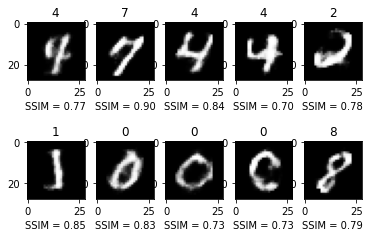

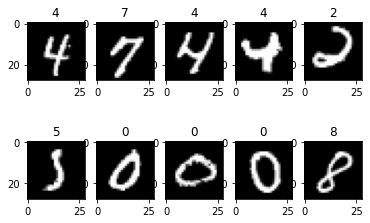

In [218]:
plot_results(test_imgs,test_origins)

In [0]:
# get the data within the specific hours
def get_test_data(N_start, N_end):  #N_start refer to the hours, eg: N_start = 3

  Final_test = []
  Final_origin = []

  for i in range(N[N_start], N[N_end]):
    if i % 2 == 1:           # 0 for Fashion Mnist and 1 for Mnist.
      Final_test.append(imgs_all[i].reshape(64,80,1))
      Final_origin.append(origins_all[i].reshape(28,28,1))

  Final_test = np.array(Final_test).astype(float)   
  Final_origin = np.array(Final_origin).astype(float)

  return Final_test/255.0, Final_origin/255.0

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


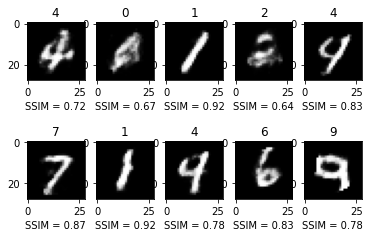

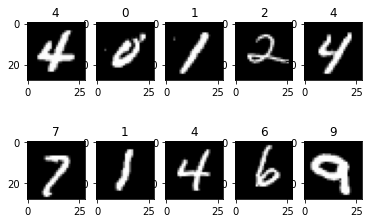

In [213]:
x, y = get_test_data(10,11)
plot_results(x,y)